# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Download the dataset
# This cell has to run only once. 
# NO need to run every time you arrive on this notebook. 

import requests
import tarfile
import os
import shutil

# Define the URL and folder paths
url = "https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz"
folder_name = "flowers"
file_name = "flower_data.tar.gz"
file_path = os.path.join(folder_name, file_name)

# Remove the folder or symbolic link if it already exists (equivalent to `rm -rf flowers`)
try:
    if os.path.islink(folder_name) or os.path.isfile(folder_name):
        os.remove(folder_name)  # Remove the symbolic link or file
    elif os.path.isdir(folder_name):
        shutil.rmtree(folder_name)  # Remove the directory
    print(f"Removed existing {folder_name} folder/file/soft link, if any.")
except FileNotFoundError:
    pass  # If the file or directory does not exist, do nothing

# Create the folder
os.makedirs(folder_name)
print(f"Created folder: {folder_name}")

# Download the file
response = requests.get(url, stream=True)

# Save the file in the 'flowers' folder
with open(file_path, "wb") as file:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            file.write(chunk)

print(f"Downloaded {file_name} to {folder_name}")

# Extract the file in the 'flowers' folder
if file_path.endswith("tar.gz"):
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=folder_name)
        print(f"Extracted {file_name} to {folder_name}")

# Clean up by removing the tar.gz file after extraction
os.remove(file_path)
print(f"Removed the downloaded tar.gz file: {file_path}")


Removed existing flowers folder/file/soft link, if any.
Created folder: flowers
Downloaded flower_data.tar.gz to flowers
Extracted flower_data.tar.gz to flowers
Removed the downloaded tar.gz file: flowers/flower_data.tar.gz


In [2]:
# Imports here
import numpy as np
from torchvision.models import vgg16, VGG16_Weights
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import tensor
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import argparse
from collections import OrderedDict
import json
import PIL
import seaborn as sns
from PIL import Image
import time

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/master/torchvision/transforms.html#)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. This converts the values of each color channel to be between -1 and 1 instead of 0 and 1.

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# TODO: Define your transforms for the training, validation, and testing sets
# Define data transforms for training, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# Define the dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=64, shuffle=True),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=64, shuffle=True)
}

# Get the size of each dataset
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'valid', 'test']}

# Print dataset sizes
print("Train Loader Size:", dataset_sizes['train'])
print("Validation Loader Size:", dataset_sizes['valid'])
print("Test Loader Size:", dataset_sizes['test'])

Train Loader Size: 103
Validation Loader Size: 13
Test Loader Size: 13


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [6]:
# TODO: Build and train your network
# Load the pre-trained VGG16 model
# VGG16 has a large number of parameters, making it computationally intensive, with a model size of over 550 MB.
# This can result in longer inference times.
# Reference: https://forums.fast.ai/t/vgg-strength-and-limitations/1218

model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# In PyTorch, when loading a model, the 'requires_grad' attribute for all parameters is set to True by default.
# This means gradients are calculated for all parameters during backpropagation, increasing memory usage.
# Since the majority of the pre-trained model is already trained, we freeze these layers by setting 'requires_grad' to False.

# Freeze all layers to prevent updating during training
for param in model.parameters():
    param.requires_grad = False

# Now, we modify the classifier (the fully connected layers at the end of VGG16) to suit our specific task.
# We'll replace the final layer with a custom Sequential block that includes Linear, ReLU, and Dropout layers.

# Using OrderedDict to maintain the order of layers
from collections import OrderedDict

# Define a new classifier with three hidden layers and a LogSoftmax output layer
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 120)),      # First hidden layer: Input size 25088, output size 120
    ('relu1', nn.ReLU()),                # ReLU activation for non-linearity
    ('dropout1', nn.Dropout(0.5)),       # Dropout with 50% probability to prevent overfitting
    ('fc2', nn.Linear(120, 90)),         # Second hidden layer: Output size 90
    ('relu2', nn.ReLU()),                # ReLU activation
    ('fc3', nn.Linear(90, 70)),          # Third hidden layer: Output size 70
    ('relu3', nn.ReLU()),                # ReLU activation
    ('fc4', nn.Linear(70, 102)),         # Final layer: Output size 102 (number of classes)
    ('output', nn.LogSoftmax(dim=1))     # LogSoftmax output for use with NLLLoss
]))

# Replace the default VGG16 classifier with the custom one
model.classifier = classifier

# Move the model to the GPU if available for faster computation
if torch.cuda.is_available():
    model.cuda()

# Define the loss function and optimizer
# Using Negative Log Likelihood (NLLLoss) which is suitable for multi-class classification.
# The Adam optimizer is selected as it adapts the learning rate for each parameter individually.

criterion = nn.NLLLoss()  # Negative Log-Likelihood Loss
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)  # Adam optimizer


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/student/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 249MB/s]  


In [7]:
print(dataloaders.keys())  


dict_keys(['train', 'valid', 'test'])


In [8]:
epochs = 5
patience = 3  # Stop if no improvement after 3 consecutive epochs
best_valid_acc = 0.0  # Track the best validation accuracy
patience_counter = 0  # Counter to track the number of non-improving epochs

for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}/{epochs}")

    # Set the model to training mode
    model.train()
    
    # Initialize epoch loss and accuracy for training
    train_loss = 0.0
    train_acc = 0.0

    # Iterate through the training batches
    for i, (inputs, labels) in enumerate(dataloaders['train']):
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Accumulate loss and accuracy
        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        correct_counts = predictions.eq(labels.view_as(predictions))
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        train_acc += acc.item() * inputs.size(0)
        
        # Print batch statistics
        print(f"Batch {i}, Training Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}")

    # Compute average training loss and accuracy for the epoch
    train_loss /= len(dataloaders['train'].dataset)
    train_acc /= len(dataloaders['train'].dataset)
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    # Perform validation after each epoch
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0

    with torch.no_grad():
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Accumulate validation loss
            valid_loss += loss.item() * inputs.size(0)
            
            # Calculate accuracy
            _, predictions = torch.max(outputs, 1)
            correct_counts = predictions.eq(labels.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            valid_acc += acc.item() * inputs.size(0)

    # Compute average validation loss and accuracy for the epoch
    valid_loss /= len(dataloaders['valid'].dataset)
    valid_acc /= len(dataloaders['valid'].dataset)
    print(f"Epoch {epoch + 1}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")

    # Early Stopping Check
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc  # Update the best accuracy
        patience_counter = 0  # Reset the patience counter
        print(f"Validation accuracy improved to {valid_acc:.4f}, saving model...")
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:                    
        patience_counter += 1  # Increment the patience counter
        print(f"No improvement in validation accuracy for {patience_counter} epoch(s).")

    # Stop training if patience is exceeded
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

print("Training complete.")


Epoch: 1/5
Batch 0, Training Loss: 4.6242, Accuracy: 0.0000
Batch 1, Training Loss: 4.6993, Accuracy: 0.0000
Batch 2, Training Loss: 4.6152, Accuracy: 0.0312
Batch 3, Training Loss: 4.7116, Accuracy: 0.0156
Batch 4, Training Loss: 4.5735, Accuracy: 0.0156
Batch 5, Training Loss: 4.5178, Accuracy: 0.0469
Batch 6, Training Loss: 4.6799, Accuracy: 0.0156
Batch 7, Training Loss: 4.7027, Accuracy: 0.0156
Batch 8, Training Loss: 4.6132, Accuracy: 0.0000
Batch 9, Training Loss: 4.5573, Accuracy: 0.0312
Batch 10, Training Loss: 4.6834, Accuracy: 0.0000
Batch 11, Training Loss: 4.6316, Accuracy: 0.0000
Batch 12, Training Loss: 4.5734, Accuracy: 0.0156
Batch 13, Training Loss: 4.6466, Accuracy: 0.0000
Batch 14, Training Loss: 4.6498, Accuracy: 0.0156
Batch 15, Training Loss: 4.4444, Accuracy: 0.0000
Batch 16, Training Loss: 4.4900, Accuracy: 0.0000
Batch 17, Training Loss: 4.4672, Accuracy: 0.0312
Batch 18, Training Loss: 4.4805, Accuracy: 0.0000
Batch 19, Training Loss: 4.5797, Accuracy: 0.0000

Batch 58, Training Loss: 2.8659, Accuracy: 0.2969
Batch 59, Training Loss: 2.7142, Accuracy: 0.3125
Batch 60, Training Loss: 2.3653, Accuracy: 0.3906
Batch 61, Training Loss: 2.5600, Accuracy: 0.3906
Batch 62, Training Loss: 2.9209, Accuracy: 0.2500
Batch 63, Training Loss: 2.9520, Accuracy: 0.2969
Batch 64, Training Loss: 2.8513, Accuracy: 0.3281
Batch 65, Training Loss: 2.5309, Accuracy: 0.2656
Batch 66, Training Loss: 2.8674, Accuracy: 0.3125
Batch 67, Training Loss: 2.9331, Accuracy: 0.2812
Batch 68, Training Loss: 2.4445, Accuracy: 0.3906
Batch 69, Training Loss: 2.7546, Accuracy: 0.3281
Batch 70, Training Loss: 2.8873, Accuracy: 0.3438
Batch 71, Training Loss: 2.7894, Accuracy: 0.2656
Batch 72, Training Loss: 2.8655, Accuracy: 0.2969
Batch 73, Training Loss: 3.0803, Accuracy: 0.2344
Batch 74, Training Loss: 3.2231, Accuracy: 0.2344
Batch 75, Training Loss: 2.6967, Accuracy: 0.3125
Batch 76, Training Loss: 2.7075, Accuracy: 0.3750
Batch 77, Training Loss: 2.5229, Accuracy: 0.3906


Batch 9, Training Loss: 2.2995, Accuracy: 0.3438
Batch 10, Training Loss: 2.1312, Accuracy: 0.4688
Batch 11, Training Loss: 1.9520, Accuracy: 0.3906
Batch 12, Training Loss: 1.9425, Accuracy: 0.5156
Batch 13, Training Loss: 2.6827, Accuracy: 0.3594
Batch 14, Training Loss: 2.6591, Accuracy: 0.3125
Batch 15, Training Loss: 1.8181, Accuracy: 0.5625
Batch 16, Training Loss: 2.2807, Accuracy: 0.4375
Batch 17, Training Loss: 1.9784, Accuracy: 0.4219
Batch 18, Training Loss: 2.0410, Accuracy: 0.4375
Batch 19, Training Loss: 2.1784, Accuracy: 0.4062
Batch 20, Training Loss: 2.0892, Accuracy: 0.4375
Batch 21, Training Loss: 2.4586, Accuracy: 0.3594
Batch 22, Training Loss: 2.1431, Accuracy: 0.4219
Batch 23, Training Loss: 2.2298, Accuracy: 0.3438
Batch 24, Training Loss: 1.8916, Accuracy: 0.5000
Batch 25, Training Loss: 2.1901, Accuracy: 0.4844
Batch 26, Training Loss: 2.5125, Accuracy: 0.3750
Batch 27, Training Loss: 1.9210, Accuracy: 0.5625
Batch 28, Training Loss: 1.9473, Accuracy: 0.4219
B

Batch 74, Training Loss: 2.0778, Accuracy: 0.4688
Batch 75, Training Loss: 1.6073, Accuracy: 0.5625
Batch 76, Training Loss: 1.8071, Accuracy: 0.5312
Batch 77, Training Loss: 1.8567, Accuracy: 0.4688
Batch 78, Training Loss: 2.2558, Accuracy: 0.4531
Batch 79, Training Loss: 2.0350, Accuracy: 0.4531
Batch 80, Training Loss: 1.8376, Accuracy: 0.4844
Batch 81, Training Loss: 1.9500, Accuracy: 0.5000
Batch 82, Training Loss: 1.8764, Accuracy: 0.4375
Batch 83, Training Loss: 1.6524, Accuracy: 0.5469
Batch 84, Training Loss: 2.3930, Accuracy: 0.3750
Batch 85, Training Loss: 1.7204, Accuracy: 0.5625
Batch 86, Training Loss: 2.0971, Accuracy: 0.5625
Batch 87, Training Loss: 2.1821, Accuracy: 0.3906
Batch 88, Training Loss: 2.0844, Accuracy: 0.4688
Batch 89, Training Loss: 1.9832, Accuracy: 0.5312
Batch 90, Training Loss: 2.1788, Accuracy: 0.4062
Batch 91, Training Loss: 1.5299, Accuracy: 0.6094
Batch 92, Training Loss: 1.8685, Accuracy: 0.5156
Batch 93, Training Loss: 1.9427, Accuracy: 0.5312


In [9]:
# Perform validation on the test set without tracking gradients
with torch.no_grad():
    
    # Set model to evaluation mode
    model.eval()

    # Validation loop over batches
    for j, (inputs, labels) in enumerate(dataloaders['valid']):
        # Move inputs and labels to GPU
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        # Forward pass to get model predictions
        outputs = model(inputs)

        # Compute loss for the batch
        loss = criterion(outputs, labels)

        # Accumulate validation loss
        valid_loss += loss.item() * inputs.size(0)

        # Calculate accuracy for the batch
        _, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        # Compute batch accuracy and accumulate it
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        valid_acc += acc.item() * inputs.size(0)

        # Print validation batch results
        print("Validation Batch: {:03d}, Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))


Validation Batch: 000, Loss: 0.8637, Accuracy: 0.7969
Validation Batch: 001, Loss: 0.7027, Accuracy: 0.7969
Validation Batch: 002, Loss: 1.2014, Accuracy: 0.6719
Validation Batch: 003, Loss: 0.9433, Accuracy: 0.7812
Validation Batch: 004, Loss: 0.8503, Accuracy: 0.7656
Validation Batch: 005, Loss: 0.8659, Accuracy: 0.7656
Validation Batch: 006, Loss: 1.2205, Accuracy: 0.7031
Validation Batch: 007, Loss: 0.8895, Accuracy: 0.7031
Validation Batch: 008, Loss: 0.9263, Accuracy: 0.7188
Validation Batch: 009, Loss: 1.3920, Accuracy: 0.6250
Validation Batch: 010, Loss: 0.9122, Accuracy: 0.7969
Validation Batch: 011, Loss: 0.9945, Accuracy: 0.7500
Validation Batch: 012, Loss: 0.9931, Accuracy: 0.7600


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [10]:
# Initialize counters for correct predictions and total images
correct = 0
total = 0

with torch.no_grad():
    model.eval()  # Set model to evaluation mode
    for images, labels in dataloaders['test']:  # Use dataloaders['test'] for the test set
        images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
        outputs = model(images)  # Get model predictions
        _, predicted = torch.max(outputs.data, 1)  # Get predicted labels
        total += labels.size(0)  # Update total number of images
        correct += (predicted == labels).sum().item()  # Update correct predictions

# Calculate and print test set accuracy
accuracy = 100 * correct / total
print(f'Accuracy on test images: {accuracy:.2f}%')



Accuracy on test images: 70.09%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [11]:
# TODO: Save the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx

torch.save({
    'architecture': 'alexnet',
    'hidden_units': 120,
    'dropout': 0.5,
    'epochs': 5,
    'state_dict': model.state_dict(),
    'class_to_idx': model.class_to_idx,
    'optimizer_state': optimizer.state_dict()
}, 'checkpoint.pth')


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [12]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
# Save model checkpoint
model.class_to_idx = image_datasets['train'].class_to_idx

torch.save({
    'architecture': 'alexnet',
    'hidden_units': 120,
    'dropout': 0.5,
    'epochs': 5,
    'state_dict': model.state_dict(),
    'class_to_idx': model.class_to_idx,
    'optimizer_state': optimizer.state_dict()
}, 'checkpoint.pth')


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [15]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch model,
    returns a Numpy array
    '''

    # Open the image
    img = PIL.Image.open(image_path)

    # Get original dimensions
    original_width, original_height = img.size

    # Resize the image so that the shorter side is 256 pixels, keeping aspect ratio
    if original_width < original_height:
        img.thumbnail((256, int(256 * original_height / original_width)))
    else:
        img.thumbnail((int(256 * original_width / original_height), 256))
    
    # Calculate coordinates for cropping the center
    center_x, center_y = img.size[0] // 2, img.size[1] // 2
    left = center_x - 112
    top = center_y - 112
    right = center_x + 112
    bottom = center_y + 112
    img = img.crop((left, top, right, bottom))

    # Convert image to Numpy array and normalize to range [0, 1]
    numpy_img = np.array(img) / 255.0 

    # Normalize each color channel using ImageNet standards
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    numpy_img = (numpy_img - mean) / std
    
    # Rearrange the dimensions to be [channel, height, width]
    numpy_img = numpy_img.transpose((2, 0, 1))
    
    return numpy_img


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

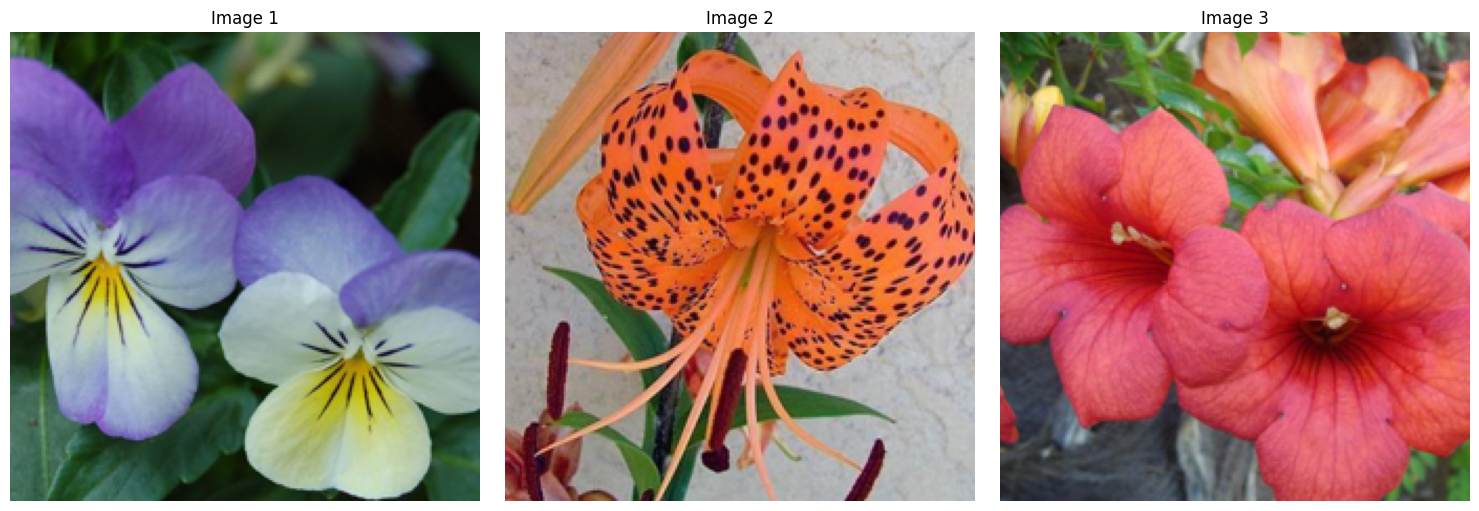

In [28]:
def imshow(image, ax=None, title=None):
    """Displays a PyTorch tensor image after undoing preprocessing."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # Convert the image from PyTorch format (C, H, W) to matplotlib format (H, W, C)
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing: denormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Clip the image to be in the range [0, 1]
    image = np.clip(image, 0, 1)
    
    # Display the image
    ax.imshow(image)
    
    if title is not None:
        ax.set_title(title)
    
    ax.axis('off')  # Hide axes
    return ax

# Example usage to display images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display three images side by side
imshow(process_image("flowers/test/52/image_04160.jpg"), ax=axs[0], title="Image 1")
imshow(process_image("flowers/test/6/image_07182.jpg"), ax=axs[1], title="Image 2")
imshow(process_image("flowers/test/101/image_07983.jpg"), ax=axs[2], title="Image 3")

plt.tight_layout()
plt.show()

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [22]:
def predict(image_path, model, top_k=5):
    """Predicts the class (or classes) of an image using a trained deep learning model.
    
    Args:
        image_path (str): Path to the image file (not a folder).
        model (torch.nn.Module): The trained PyTorch neural network model.
        top_k (int): The number of top classes to return.
    
    Returns:
        tuple: Top probabilities, top labels, and top flower names.
    """
    
    # Move model to CPU for inference
    model.to("cpu")
    
    # Set model to evaluation mode
    model.eval()

    # Process the image and convert to a PyTorch tensor
    torch_image = torch.from_numpy(np.expand_dims(process_image(image_path), axis=0)).type(torch.FloatTensor).to("cpu")

    # Forward pass: get log probabilities from the model
    log_probs = model.forward(torch_image)

    # Convert log probabilities to linear scale
    linear_probs = torch.exp(log_probs)

    # Retrieve the top K probabilities and their corresponding class indices
    top_probs, top_labels = linear_probs.topk(top_k)
    
    # Detach tensors and convert to NumPy arrays
    top_probs = top_probs.detach().numpy()[0]  # Get top probabilities
    top_labels = top_labels.detach().numpy()[0]  # Get top label indices
    
    # Map indices to class labels
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labels]
    
    # Convert label indices to flower names
    top_flowers = [cat_to_name[lab] for lab in top_labels]
    
    return top_probs, top_labels, top_flowers

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

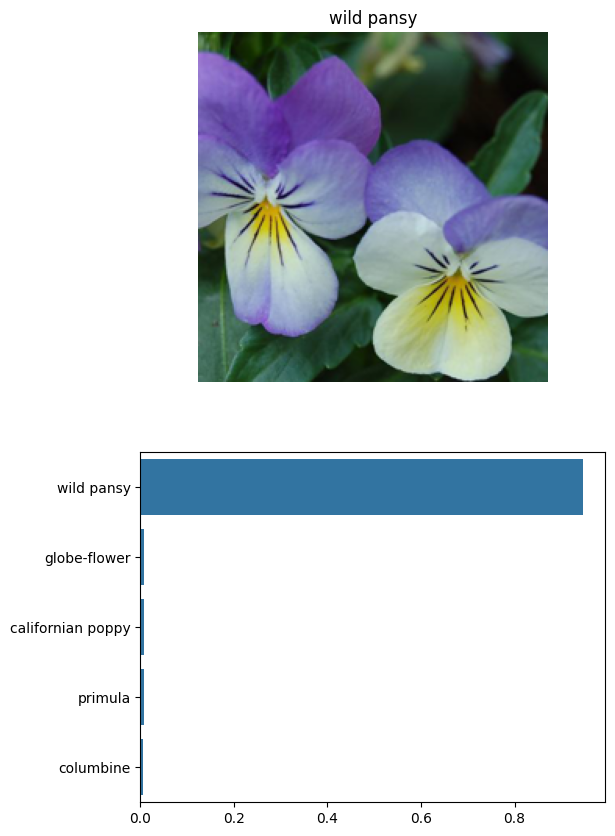

In [25]:
# TODO: Display an image along with the top 5 classes
# Define the image path
image_path = "flowers/test/52/image_04160.jpg"

# Set up the figure for the plot
plt.figure(figsize=(6, 10))

# Set up the title using the flower number extracted from the image path
flower_num = image_path.split('/')[2]
title_ = cat_to_name[flower_num]

# Plot the flower image
ax = plt.subplot(2, 1, 1)  # Create a subplot
img = process_image(image_path)  # Process the image for display
imshow(img, ax, title=title_)  # Show the image with the title

# Make predictions using the model
probs, labs, flowers = predict(image_path, model)

# Plot the bar chart for the top 5 classes
plt.subplot(2, 1, 2)  # Create another subplot
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0])  # Plot the probabilities against flower names

# Show the complete figure
plt.show()

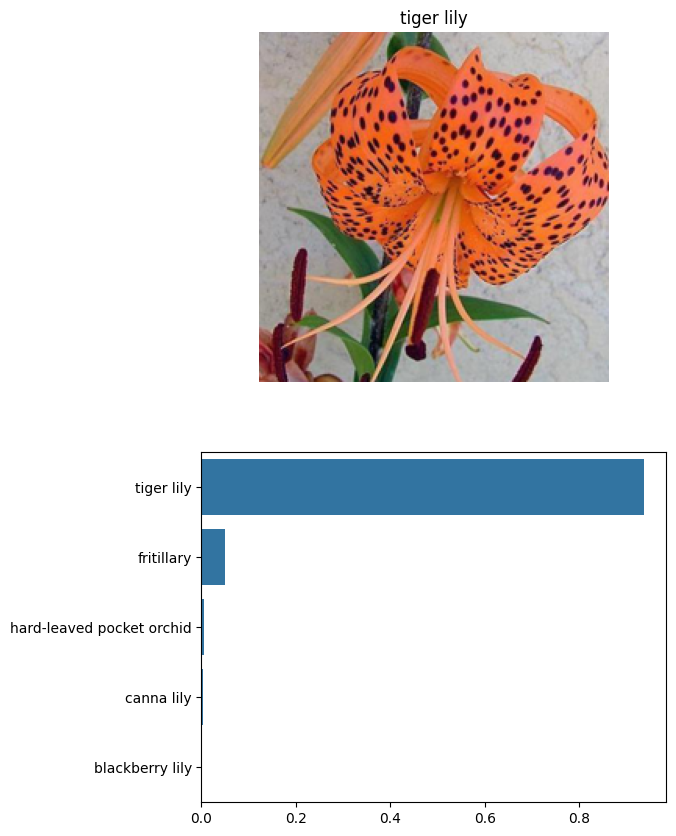

In [29]:
# Define the image path
image_path = "flowers/test/6/image_07182.jpg"

# Set up the figure for the plot
plt.figure(figsize=(6, 10))

# Extract flower number and title from the image path
flower_num = image_path.split('/')[2]
title_ = cat_to_name[flower_num]

# Create the first subplot for the image
ax = plt.subplot(2, 1, 1)
img = process_image(image_path)  # Process the image for display
imshow(img, ax, title=title_)  # Display the image with the title

# Make predictions using the model
probs, labs, flowers = predict(image_path, model)

# Create the second subplot for the bar chart
plt.subplot(2, 1, 2)
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0])  # Plot probabilities against flower names

# Show the complete figure
plt.show()